In [ ]:
#import libraries
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Image Data Generator

In [ ]:
# ImageDataGenerator

height, width = 224, 224
batch_size=64

def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)

    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

TRAINING_DIR = '/content/drive/MyDrive/Covid19-dataset/train'
TESTING_DIR = '/content/drive/MyDrive/Covid19-dataset/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'Normal_cases':len(np.where(total_image==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(total_image==1)[0]),
             'Covid_cases':len(np.where(total_image==2)[0])})

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


 {'Normal_cases': 90, 'Viral_Pneumonia_cases': 90, 'Covid_cases': 137}


# Displaying Images

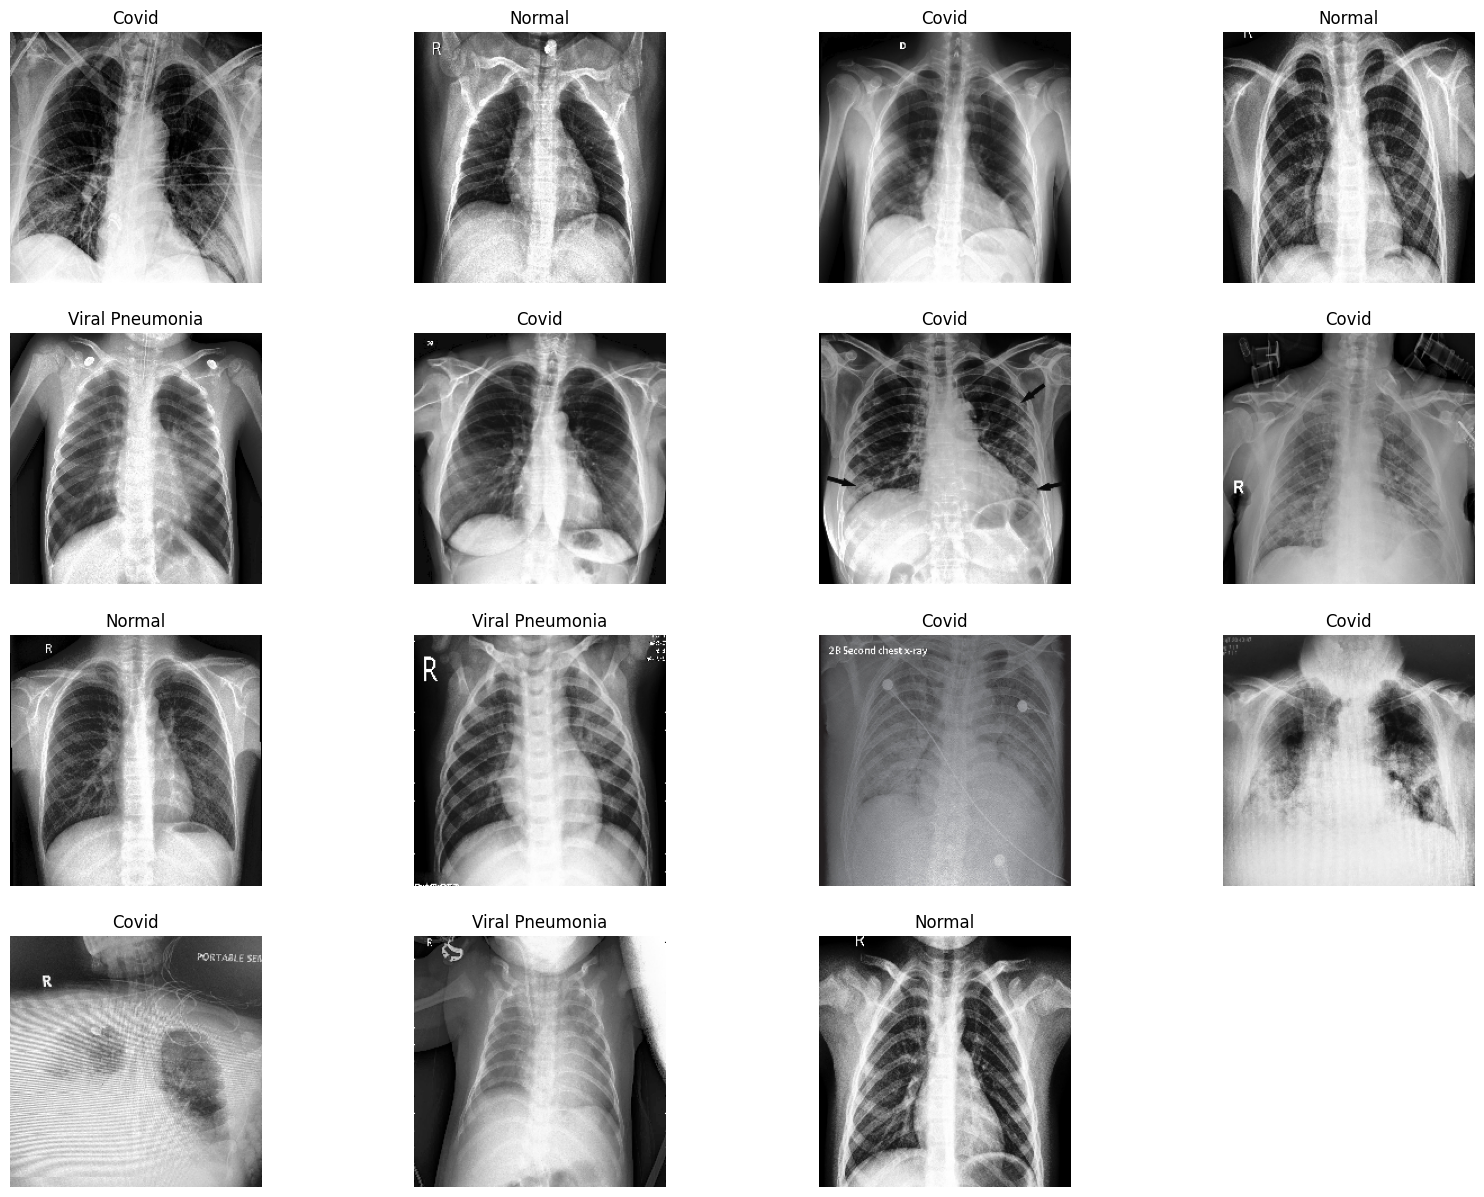

In [ ]:
#display image
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,15)

# Model Architecture

In [ ]:
#define ResNet18 Model

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_resnet50 = tf.keras.Sequential()
model_resnet50.add(base_model)
model_resnet50.add(tf.keras.layers.GlobalAveragePooling2D())

model_resnet50.add(tf.keras.layers.Flatten())
model_resnet50.add(tf.keras.layers.Dense(256, activation='relu'))
model_resnet50.add(tf.keras.layers.Dropout(0.5))
model_resnet50.add(tf.keras.layers.Dense(256, activation='relu'))
model_resnet50.add(tf.keras.layers.Dropout(0.5))

model_resnet50.add(tf.keras.layers.Dense(3, activation='softmax'))

model_resnet50.compile(loss='SparseCategoricalCrossentropy',
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['acc'])
model_resnet50.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65

# Training

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
# early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True)

callbacks_list = [checkpoint]

history = model_resnet50.fit(
        train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=100,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.0759 - acc: 0.4422
Epoch 1: acc improved from -inf to 0.44223, saving model to model/resnet50_best.h5
4/4 [==============================] - 14s 4s/step - loss: 1.0759 - acc: 0.4422 - val_loss: 1.0956 - val_acc: 0.3939
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.0771 - acc: 0.4422
Epoch 2: acc did not improve from 0.44223
4/4 [==============================] - 14s 4s/step - loss: 1.0771 - acc: 0.4422 - val_loss: 1.0951 - val_acc: 0.3939
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.0723 - acc: 0.4422
Epoch 3: acc did not improve from 0.44223
4/4 [==============================] - 14s 4s/step - loss: 1.0723 - acc: 0.4422 - val_loss: 1.0939 - val_acc: 0.3939
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 1.0753 - acc: 0.4422
Epoch 4: acc did not improve from 0.44223
4/4 [==============================] - 15s 4s/step - loss: 1.0753 - acc: 0.4422 - val_lo

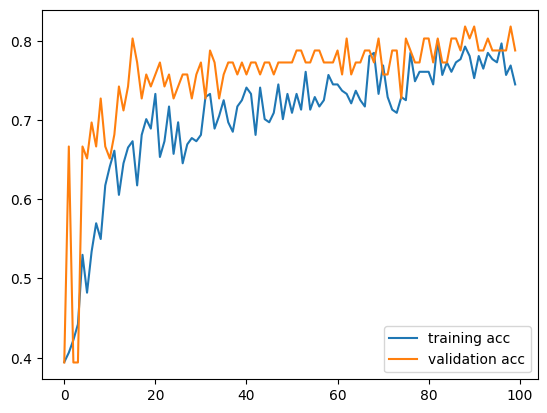

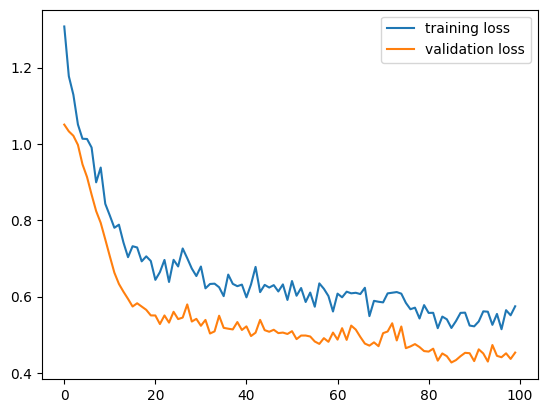

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [ ]:
#get results
train_result = model_resnet50.evaluate(train_generator)
test_result = model_resnet50.evaluate(test_generator)

no_augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 2s 21ms/step - loss: 0.4531 - acc: 0.7879


Train       Val
Loss  0.457575  0.453148
Acc   0.816733  0.787879

3/3 [==============================] - 0s 118ms/step
              precision    recall  f1-score   support

         0.0       0.66      0.95      0.78        20
         1.0       0.75      0.45      0.56        20
         2.0       0.96      0.92      0.94        26

    accuracy                           0.79        66
   macro avg       0.79      0.77      0.76        66
weighted avg       0.80      0.79      0.78        66



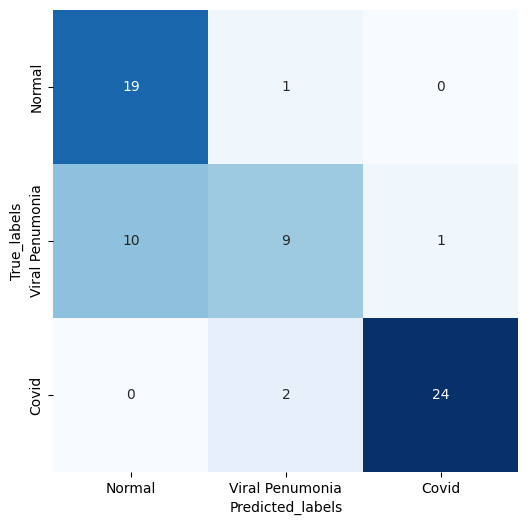

In [ ]:
#model accuracy
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0])
    ytest= np.concatenate((ytest,test_generator[i][-1]))

xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_resnet50.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

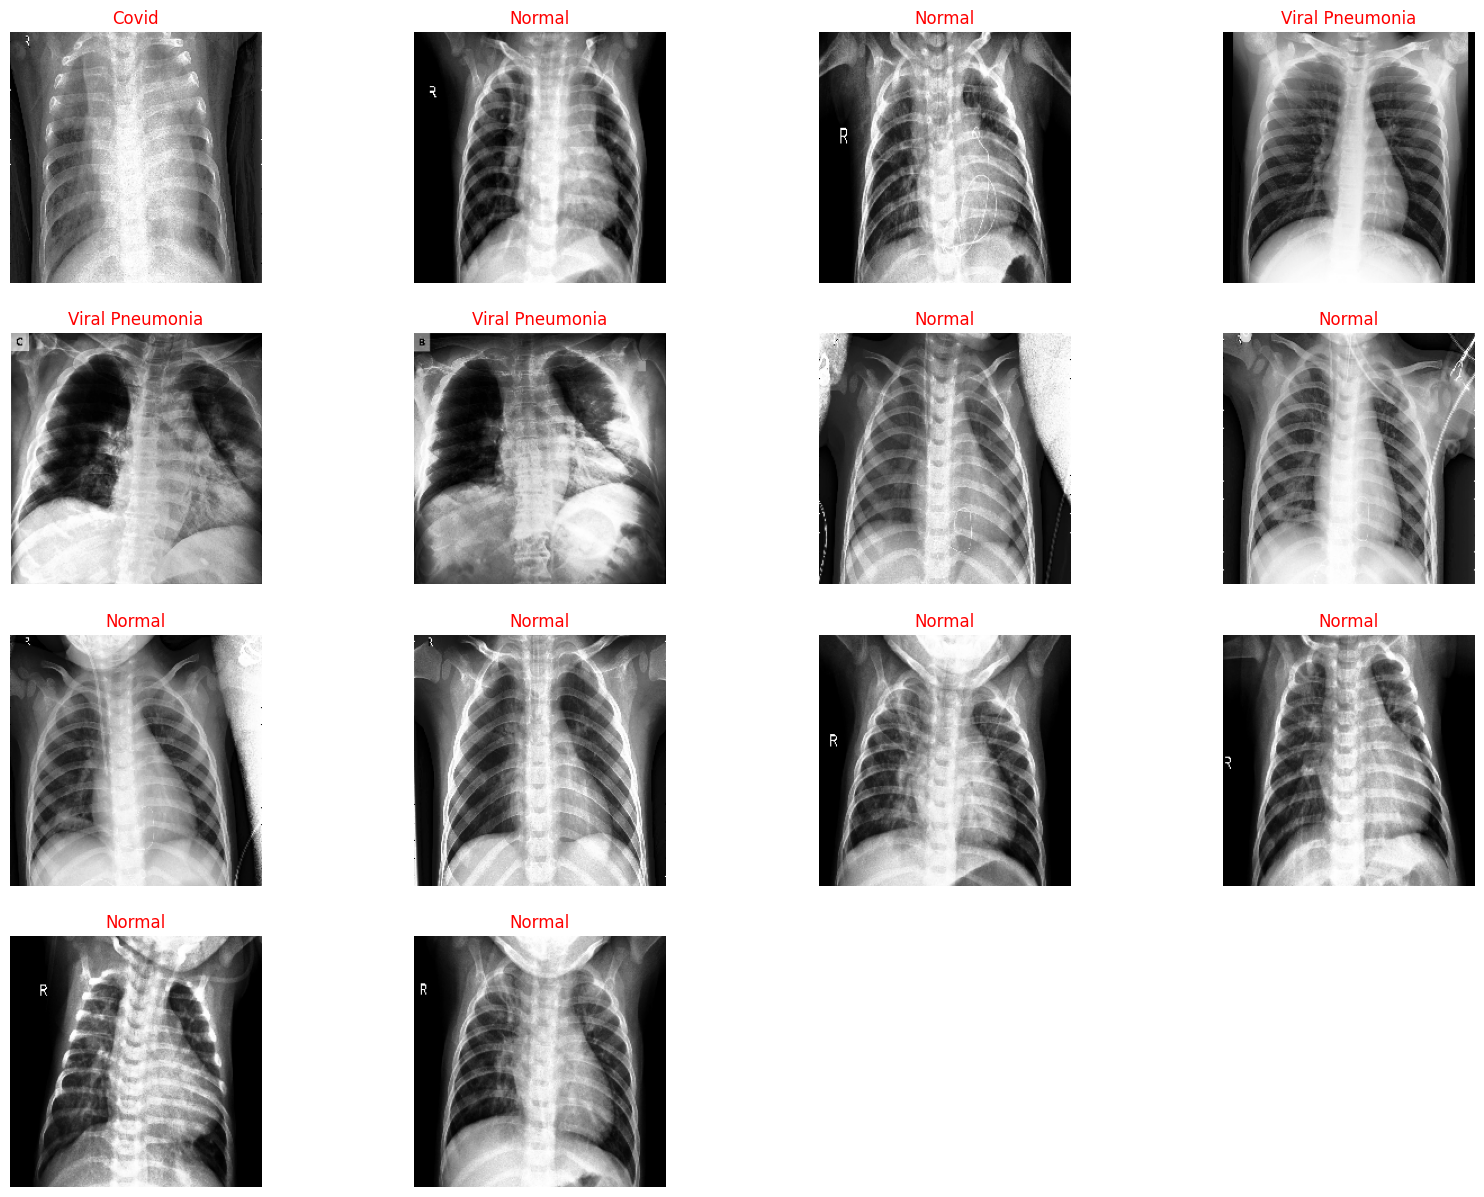

In [ ]:
#Extract wrong classification index
wrong_pred = np.where(ypred!=ytest)[0]

plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
    plt.imshow(xtest[n])
    plt.title("Normal" if ypred[n] == 0 else "Viral Pneumonia" if ypred[n] == 1 else "Covid",color='r')
    plt.axis("off")

Found 251 images belonging to 3 classes.


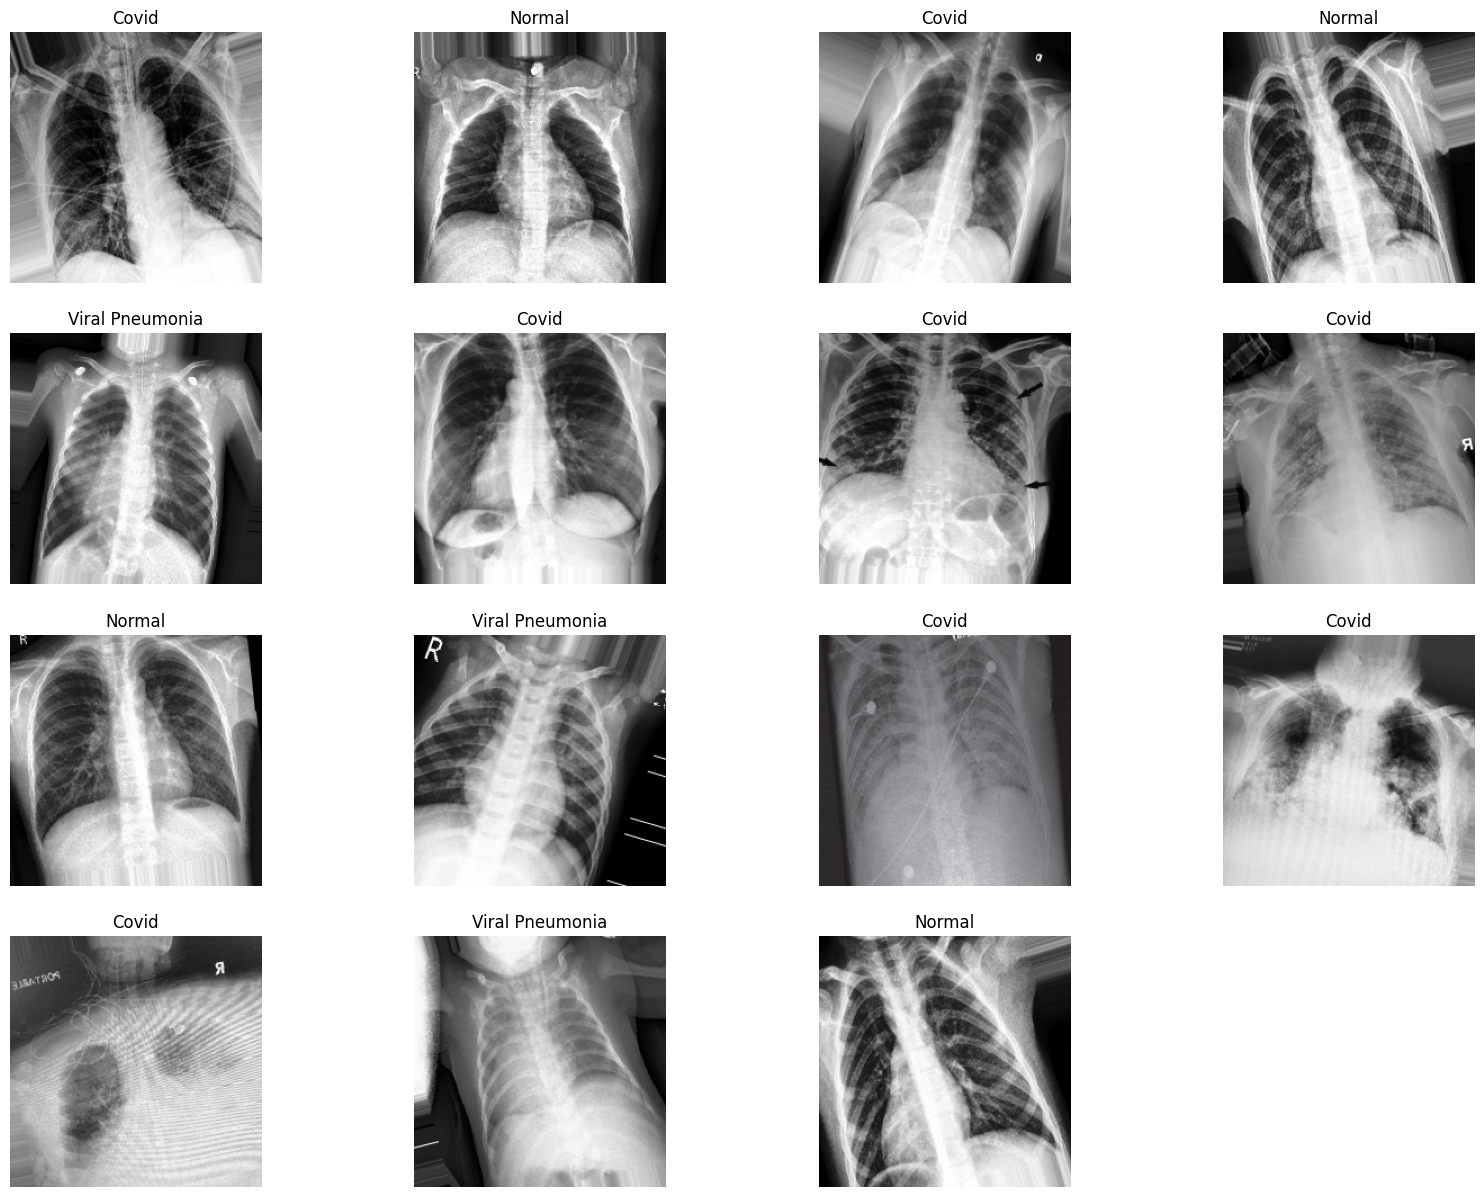

In [ ]:
#adding image augmentation
def generate_data_augmented(DIR):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        zoom_range=0.1,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True
    )
    generator = datagen.flow_from_directory(
        TRAINING_DIR,
        batch_size= batch_size,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

aug_train_generator = generate_data_augmented(TRAINING_DIR)

image_plot(aug_train_generator,15)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50_best_augmentation.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
# early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=10)

callbacks_list = [checkpoint]

history = model_resnet50.fit(
        aug_train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=100,
        shuffle=False,
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 0.6718 - acc: 0.7131
Epoch 1: acc improved from -inf to 0.71315, saving model to model/resnet50_best_augmentation.h5
4/4 [==============================] - 20s 5s/step - loss: 0.6718 - acc: 0.7131 - val_loss: 0.5642 - val_acc: 0.6970
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.6628 - acc: 0.7251
Epoch 2: acc improved from 0.71315 to 0.72510, saving model to model/resnet50_best_augmentation.h5
4/4 [==============================] - 17s 4s/step - loss: 0.6628 - acc: 0.7251 - val_loss: 0.5039 - val_acc: 0.7576
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.6507 - acc: 0.7211
Epoch 3: acc did not improve from 0.72510
4/4 [==============================] - 16s 4s/step - loss: 0.6507 - acc: 0.7211 - val_loss: 0.5274 - val_acc: 0.7576
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 0.6798 - acc: 0.6892
Epoch 4: acc did not improve from 0.72510
4/4 [=============

In [ ]:
train_result = model_resnet50.evaluate(train_generator)
test_result = model_resnet50.evaluate(test_generator)

augmented_df = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 2s 23ms/step - loss: 0.2952 - acc: 0.9242


Train       Val
Loss  0.291933  0.295222
Acc   0.892430  0.924242

8/8 [==============================] - 5s 665ms/step
              precision    recall  f1-score   support

         0.0       0.77      0.96      0.85        70
         1.0       0.95      0.84      0.89        70
         2.0       0.96      0.88      0.92       111

    accuracy                           0.89       251
   macro avg       0.89      0.89      0.89       251
weighted avg       0.91      0.89      0.89       251



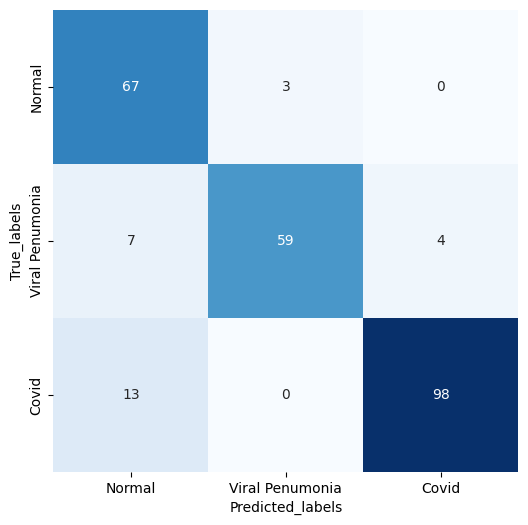

In [ ]:
#final model evaluation
ytrain = np.array([])
xtrain = []

for i in range(math.ceil(len(train_generator.classes)/batch_size)):
    xtrain.append(train_generator[i][0])
    ytrain= np.concatenate((ytrain,train_generator[i][-1]))

xtrain = np.concatenate((xtrain),axis=0)

ypred_prob =model_resnet50.predict(xtrain)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytrain,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytrain,ypred))

3/3 [==============================] - 0s 150ms/step
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.88        20
         1.0       0.94      0.80      0.86        20
         2.0       1.00      1.00      1.00        26

    accuracy                           0.92        66
   macro avg       0.92      0.92      0.92        66
weighted avg       0.93      0.92      0.92        66



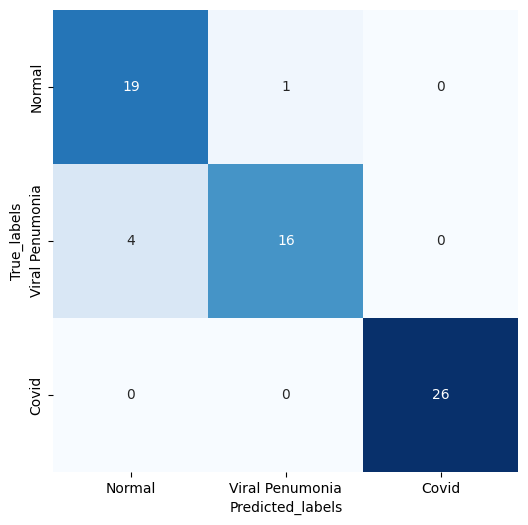

In [ ]:
ytest = np.array([])
xtest = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    xtest.append(test_generator[i][0])
    ytest= np.concatenate((ytest,test_generator[i][-1]))

xtest = np.concatenate((xtest),axis=0)

ypred_prob =model_resnet50.predict(xtest)
ypred = np.argmax(ypred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(ytest,ypred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted_labels')
hm.set(ylabel='True_labels')
print(classification_report(ytest,ypred))

# Saliency Maps

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def saliency_map(image, model):

  # Convert the image to a TensorFlow tensor
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)

  # Resize the image to the input size of the model
  image = tf.image.resize(image, [224, 224])

  # Add a batch dimension to the image
  image = tf.expand_dims(image, axis=0)

  # Forward pass the image through the model
  ypred_prob = model.predict(image)
  output = tf.argmax(ypred_prob, axis=1)

  # Get the index of the predicted class
  class_index = tf.squeeze(output)
  print('Predicted label:', class_index)

  # Create a saliency map
  with tf.GradientTape() as tape:
      tape.watch(image)
      predictions = model(image)
      top_prediction = tf.reduce_max(predictions)
  saliency_map = tape.gradient(top_prediction, image)

  # Normalize the saliency map
  saliency_map = tf.abs(saliency_map) / tf.reduce_max(saliency_map)
  return saliency_map

1/1 [==============================] - 0s 19ms/step
Predicted label: tf.Tensor(2, shape=(), dtype=int64)


True class index: 2.0


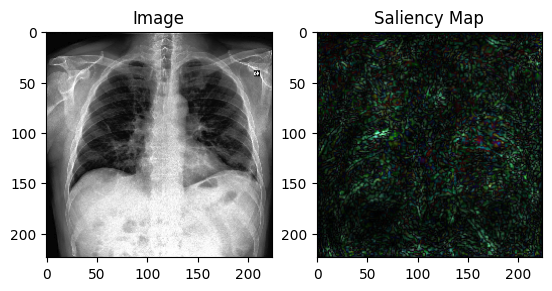

1/1 [==============================] - 0s 28ms/step
Predicted label: tf.Tensor(0, shape=(), dtype=int64)


True class index: 0.0


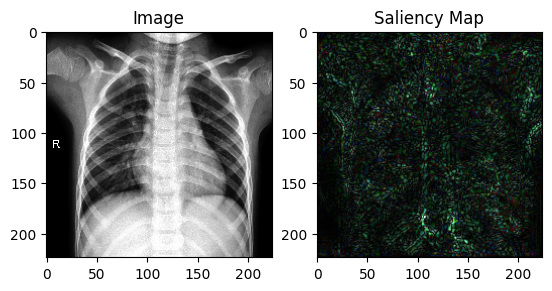

1/1 [==============================] - 0s 21ms/step
Predicted label: tf.Tensor(1, shape=(), dtype=int64)


True class index: 1.0


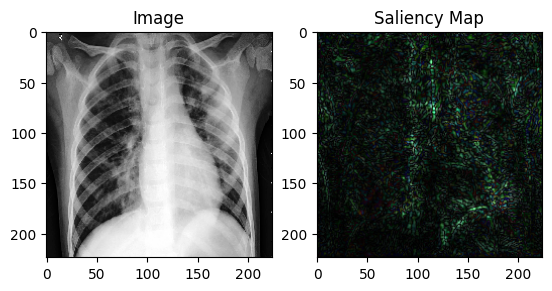

In [ ]:
model = model_resnet50
image = test_generator[0][0][4]
true_image_index = test_generator[0][1][4]
images = [test_generator[0][0][13], test_generator[0][0][14], test_generator[0][0][15]]
indexes = [13, 14, 15]
# Plot the image and the saliency map
for i,image in enumerate(images):
  map = saliency_map(image,model)
  print('True class index:', test_generator[0][1][indexes[i]])
  plt.subplot(1, 2, 1)
  plt.imshow(tf.squeeze(image))
  plt.title('Image')

  plt.subplot(1, 2, 2)
  plt.imshow(tf.squeeze(map), cmap='jet')
  plt.title('Saliency Map')
  plt.show()

In [ ]:
test_generator[0][0][1]

array([[[0.0509804 , 0.0509804 , 0.0509804 ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.10588236, 0.10588236, 0.10588236],
        [0.05490196, 0.05490196, 0.05490196],
        [0.05490196, 0.05490196, 0.05490196],
        ...,
        [0.05882353, 0.05882353, 0.05882353],
        [0.05882353, 0.05882353, 0.05882353],
        [0.00392157, 0.00392157, 0.00392157]],

       [[0.10980393, 0.10980393, 0.10980393],
        [0.0627451 , 0.0627451 , 0.0627451 ],
        [0.05490196, 0.05490196, 0.05490196],
        ...,
        [0.0509804 , 0.0509804 , 0.0509804 ],
        [0.0509804 , 0.0509804 , 0.0509804 ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.5019608 , 0.5019608 , 0.5019608 ],
        [0.52156866, 0.52156866, 0.52156866],
        [0.6156863 , 0